# 1. HW3
### Or Wolkimir (308402163) and Afek Adler (204249239) 
This is our solution for applying variational autoencoder, M1 scheme,
as part of the paper "Semi-supervised Learning with Deep Generative Models", by Kingsma et al. It is based on a VAE for feature extraction, and then a (transductive) SVM for classification.

All configurations can be changed in the **config** section. There is no reason to manipulate other code sections.

The code Was written in this fashion in order to be **easily modified and extended** (more complicated scinerios) so maybe it appears to have some code overhead.

We added our graphs (for ~50 epochs and detailed explanations in the attached pdf).

In [1]:
import numpy as np
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab
import torch
from torchvision import datasets, transforms
import helper
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import summary
import datetime
import pandas as pd
from collections import OrderedDict
from os import mkdir
from os.path import isdir
from glob import glob
from pathlib import Path
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss
from sklearn.model_selection import GridSearchCV
from torch.utils.data.sampler import SubsetRandomSampler
from functools import reduce
from operator import __or__
from sklearn.externals import joblib
from IPython.display import display

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# 2. Model


In [0]:
class Encoder(nn.Module): # q(z|X)

    def __init__(self, input_dim, hidden_dim, latent_dim):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of F-MNIST it is 28 * 28)
        '''
        super().__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim) # mean
        self.fc2_var = nn.Linear(hidden_dim, latent_dim) # standard deviation
        self.sp = nn.Softplus()
        
        
    def forward(self, x): 
        # all hidden layers
        x = self.fc1(x) #shape [batch_size, hidden_dim]
        x = self.sp(x) #shape [batch_size, hidden_dim]
        # final layer
        mu = self.fc2_mu(x) #shape [batch_size, latent_dim]
        log_var = self.fc2_var(x) #shape [batch_size, latent_dim]
        return mu, log_var

class Decoder(nn.Module): #P(X|z)
  def __init__(self, latent_dim, hidden_dim, output_size):
    '''
    Args:
        input_dim: A integer indicating the size of input (in case of F-MNIST 28 * 28).
        hidden_dim: A integer indicating the size of hidden dimension.
        latent_dim: A integer indicating the latent size.
        output_size: A integer indicating the number of classes. (dimension of one-hot representation of labels)
    '''
    super().__init__()
      
    # define hidden linear layers
    self.fc1 = nn.Linear(latent_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_size)
    self.sp = nn.Softplus()
    self.softamx = torch.nn.Softmax()

  def forward(self, x):
    # all hidden layers
    p_x = self.fc1(x) # shape [batch_size, latent_dim]
    p_x = self.sp(p_x) # shape [batch_size, hidden_dim]
    # final layer with tanh applied
    p_x = self.fc2(p_x) # shape [batch_size, output_size]
    predicted  = torch.sigmoid(p_x)
    return predicted


class VAE(nn.Module):
  ''' This the VAE, creates the encoder an decoder.

  '''
  def __init__(self, input_dim=784, hidden_dim=50, latent_dim=100):
    super().__init__()
    self.enc =  Encoder(input_dim, hidden_dim, latent_dim)
    self.dec = Decoder(latent_dim, hidden_dim, input_dim)

  def reparameterize(self, mu, logvar):
    '''
    mu : [batch_size, latent_dim] mean matrix
    logvar : [batch_size, latent_dim] variance matrix 
    '''
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

  def forward(self, x):
    # encode
    mu, logvar = self.enc(x)
    # reparameterize
    x_sample = self.reparameterize(mu, logvar) #z
    # decode
    predicted = self.dec(x_sample)
    return predicted, mu, logvar


# 3. VAE Trainer

In [0]:
class Trainer:
  def __init__(self, model,config):
    self.model = model
    self.batch_size = config.batch_size
    self.model_name = config.model_name
    self.seed = config.seed
    self.lr = config.lr
    self.epochs = config.epochs
    self.save_model = config.save_model
    self.upload_model = config.upload_model
    self.model_weights_path = config.model_weights_path
    self.criterion = self.loss_criterion
    self.optimizer = optim.RMSprop(self.model.parameters(), lr = self.lr)
    torch.manual_seed(self.seed)
    self.results = {}
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
      self.model.to(self.device)

  def get_results(self):
    return pd.DataFrame.from_dict(self.results)

  def loss_criterion(self, decoded, original, logvar, mu):
    # Reconstruction loss
    'inputs:x_sample, targets:x'
    bce_loss = F.binary_cross_entropy(decoded, original, reduction="sum")
    #MSE = torch.mean((decoded - original)**2)
    # Regularization term
    kl_loss = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())
    loss = bce_loss + kl_loss
    #loss /= self.batch_size * 784
    return loss

  def record(self,epoch,**kwargs):
    epoch = "{:02d}".format(epoch)
    temp = f"| epoch   # {epoch} :"
    for key, value in kwargs.items():
      key = f"{self.model_name}_{key}"
      if not self.results.get(key):
        self.results[key] =[]
      self.results[key].append(value)
      val = '{:.2f}'.format(np.round(value,2))
      temp += f"{key} : {val}      |       "
    print(temp)

  def fit(self,trainloader, testloader, exp_name): 
    for epoch in range(1,self.epochs+1):
      weights_path = Path(f"{self.model_weights_path}/{config.model_name}_{epoch}.pth")
      if weights_path.exists() and self.upload_model:
        epoch_train_loss = self.load_checkpoint(weights_path,epoch)
      else:
        epoch_train_loss = self.run_epoch(trainloader)
        epoch_train_loss /= len(trainloader)
      epoch_test_loss = self.test(testloader)
      epoch_test_loss /= len(testloader)
      self.record(epoch,train_loss = epoch_train_loss, test_loss = epoch_test_loss)
      self.save_checkpoint(weights_path,epoch_train_loss)


  def run_epoch(self,trainloader):
      self.model.train()
      train_loss = 0
      for images, labels in trainloader:
        images = images.view(-1, 28 * 28) # flatten image
        images = images.to(self.device)
        # forward pass
        images_sample, mu, logvar = self.model(images)
        #loss
        loss = self.criterion(images_sample, images , mu, logvar)
        self.optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        self.optimizer.step()
      return train_loss


  def test(self,test_loader):
    self.model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28 * 28)
            images = images.to(self.device)
            images_sample, mu, logvar = self.model(images)
            loss = self.criterion(images_sample, images , mu, logvar)
            test_loss += loss.item()
    return test_loss
  
  def predict(self,loader):
    self.model.eval()
    with torch.no_grad():
      for images, labels in loader:
        images = images.view(-1, 28 * 28) # flatten image
        images = images.to(self.device)
        images_sample, mu, log_var = self.model(images)
        mu_array = mu.cpu().data.numpy()
        log_array = log_var.cpu().data.numpy()
        x = np.concatenate((mu_array, log_array), axis=1)
        y = labels.cpu().data.numpy()
        
        #sample one image for plotting
        batch_size = images.size(0)
        indices = torch.randint(0, batch_size, (1,))
        
        self.model.train()
        yield images[indices], images_sample[indices], x, y

  def save_checkpoint(self,weights_path,loss):
    if (not weights_path.exists()) and self.save_model: 
      torch.save({'model_state_dict': self.model.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),'loss': loss}, weights_path)
      
  def load_checkpoint(self,weights_path,epoch):
    checkpoint = torch.load(weights_path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.model.to(self.device)
    loss = checkpoint['loss']
    print(f"Uploaded weights succesfuly at epoch number {epoch}")
    return loss

  def load_model(self):
    weights_path = Path(f"{self.model_weights_path}/{self.model_name}_{self.epochs}.pth")
    checkpoint = torch.load(weights_path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.model.to(self.device)


# 4. Utils
Utility functions for the code

In [0]:
class Config:  
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

  def add_attributes(self,**kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

def create_directories(l):
  for directory_path in l:
    if not (isdir(directory_path)):
      mkdir(directory_path)

def download_data():
  # Define a transform to covert to tensor 
  transform = transforms.Compose([transforms.ToTensor()])
  # Download and load the training data
  trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
  # Download and load the test data
  testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
  return trainset, testset

def get_loaders(dataset, batch_size):
  loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
  return loader

def get_sampler(labels, n_labels=10, n=None):
    # Only choose digits in n_labels
    (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

    # Ensure uniform distribution of labels
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])

    indices = torch.from_numpy(indices)
    sampler = SubsetRandomSampler(indices)
    return sampler

# create semi-supervised datasets of labeled and unlabeled data with equal number of labels from each class
def create_semisupervised_loaders(batch_size, labels_per_class=10):
  labelled = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2,
                                          sampler=get_sampler(trainset.targets.numpy(), 10, labels_per_class))
  validation = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=2, 
                                            sampler=get_sampler(testset.targets.numpy()))

  return labelled, validation

# 5. Configurations 

In [5]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_PATH = '/content/drive/My Drive/university/projects/DL/HW3/ex3_204249239_308402163/VAE/'
MODEL_WEIGHTS_DIR = 'model_weights'
GRAPHS_FOLDER_NAME = 'graphs'
model_weights_dir = f"{ROOT_PATH}{MODEL_WEIGHTS_DIR}" 
graphs_dir = f"{ROOT_PATH}{GRAPHS_FOLDER_NAME}" 

def get_base_config():
  ####################################################################
  # model consistency options
  SAVE_TO_CHECKPOINTS = False # if true, saves model.name_epcoch file into the weights folder
  LOAD_CHECKPOINTS = True # if true, every epoch tries to load pretrained weights
  LOAD_TRAINED_MODEL = True # if true, load VAE model after finished training (last epoch)
  SAVE_SVM = False # if true, saves model.name_epcoch file into the weights folder
  LOAD_SVM = True # if true, tries to load pretrained weights of svm
  ####################################################################
  # if needed, can be modified to upload the 'best model'
  return Config(
          seed = 2, lr = 0.0003,epochs = 50,save_model = SAVE_TO_CHECKPOINTS, save_model_svm = SAVE_SVM, upload_model_svm = LOAD_SVM,
          upload_model = LOAD_CHECKPOINTS, upload_trained_model = LOAD_TRAINED_MODEL, model_weights_path = model_weights_dir,
          batch_size=16)
INPUT_DIM = 28*28
HIDDEN_LAYER_DIM = 600
LATENT_DIM = 50
EXPERIMENTS =  ['no_regulizer']  # default run: all experiments
SAVE_FIGS = True

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 6. Run VAE experiments

In [0]:
def run_exp(experiments,trainloader, testloader):
  # create weights directory
  create_directories([graphs_dir,model_weights_dir])
  results = []
  for exp_name in experiments:
    print(f"{'#'*50} \n running {exp_name} experiment\n{'#'*50} \n") 
    config.add_attributes(model_name = exp_name)
    model = VAE(input_dim= INPUT_DIM, hidden_dim=HIDDEN_LAYER_DIM, latent_dim=LATENT_DIM)
    trainer = Trainer(model,config)
    trainer.fit(trainloader, testloader, exp_name)
    results.append(trainer.get_results())
  return trainer, results

In [7]:
config = get_base_config()
trainset, testset = download_data()
trainloader_labeld, testloader = get_loaders(trainset,config.batch_size), get_loaders(testset,config.batch_size)
trainer, results = run_exp(EXPERIMENTS, trainloader_labeld, testloader)

0it [00:00, ?it/s]

26427392it [00:02, 10391470.41it/s]                             


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 72989.74it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:01, 2982686.66it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


8192it [00:00, 27209.49it/s]            


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!
################################################## 
 running no_regulizer experiment
################################################## 

Uploaded weights succesfuly at epoch number 1
| epoch   # 01 :no_regulizer_train_loss : 4262.48      |       no_regulizer_test_loss : 4047.05      |       
Uploaded weights succesfuly at epoch number 2
| epoch   # 02 :no_regulizer_train_loss : 3997.02      |       no_regulizer_test_loss : 3947.91      |       
Uploaded weights succesfuly at epoch number 3
| epoch   # 03 :no_regulizer_train_loss : 3926.82      |       no_regulizer_test_loss : 3898.24      |       
Uploaded weights succesfuly at epoch number 4
| epoch   # 04 :no_regulizer_train_loss : 3890.57      |       no_regulizer_test_loss : 3873.43      |       
Uploaded weights succesfuly at epoch number 5
| epoch   # 05 :no_regulizer_train_loss : 

# 7. Visualizing the results of the VAE

<Figure size 432x288 with 0 Axes>

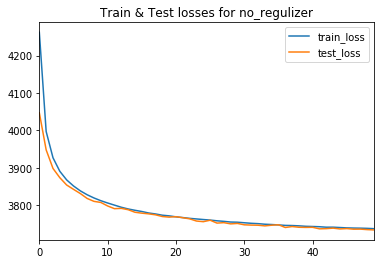

In [8]:
results_df = pd.concat(results,axis = 1)
for exp in EXPERIMENTS:
  suffixes =  ['train_loss','test_loss']
  cols = [f"{exp}_{suffix}" for suffix in suffixes]
  temp_df = results_df[cols]
  temp_df.columns =  suffixes 
  plt.figure()
  temp_df.astype(float).plot(title= F"Train & Test losses for {exp}")
  if SAVE_FIGS:
    plt.savefig(graphs_dir+ F"/{exp}.png")

We draw from each class an image and plot the original image vs the decoded image that is outputed from the network.

10


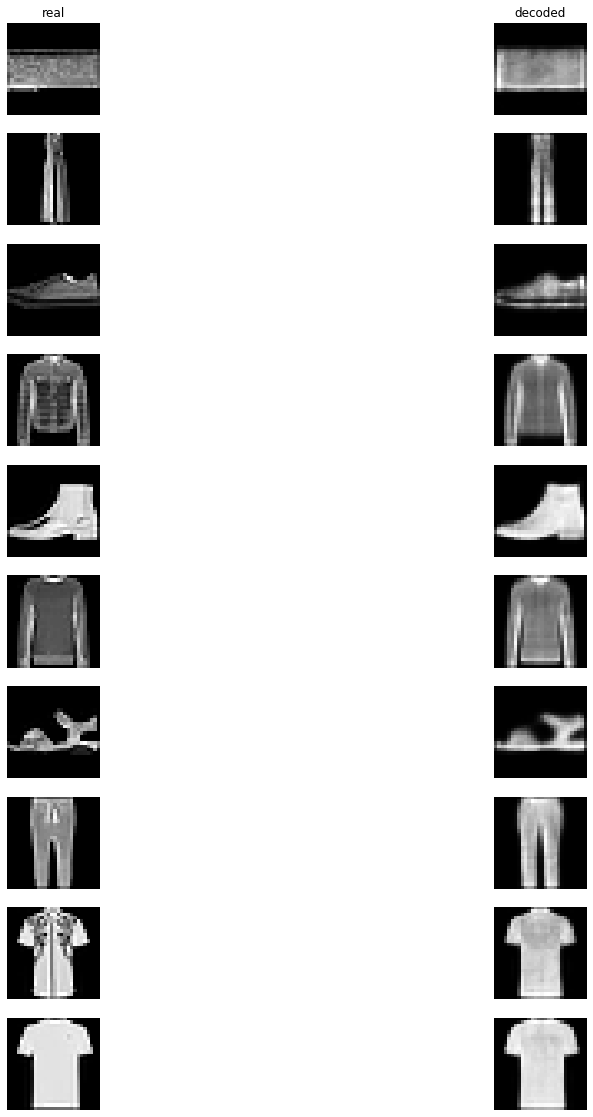

In [9]:
  def plot_images(images, decoded_images):
    fig, axs = plt.subplots(10,2, figsize=(16, 20))
    cols = ['real','decoded']
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
    axs = axs.ravel()
    counter = 0
    for im,smp in zip(images,decoded_images):
      im = im.detach().cpu().numpy().reshape((28,28))
      smp = smp.detach().cpu().numpy().reshape((28,28))
      axs[counter].imshow(im, cmap='gray')
      axs[counter+1].imshow(smp, cmap='gray')
      axs[counter].axis('off')
      axs[counter+1].axis('off')
      counter+=2

labels_per_class = 1
sample_for_plotting = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          sampler=get_sampler(trainset.targets.numpy(), 10, labels_per_class))
print (len(sample_for_plotting))
images, sample, X_train, Y_train = zip(*trainer.predict(sample_for_plotting))
plot_images(images, sample)

# 8. Train an SVM

In [0]:
class SVM():
  # Create the parameter grid based on the results of random search 
  params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                 {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                 {'kernel':['poly'],'degree':[2,3], 'C': [1, 10, 100, 1000]}]

  def __init__(self, params = params_grid):
    self.svc = svm.SVC()
    self.params = params
    self.clf = GridSearchCV(self.svc, self.params, return_train_score=True)

class SVMTrainer():
  def __init__(self, config, exp, l, model=None):
      self.save_model = config.save_model_svm
      self.model_name = exp
      self.model_weights_path = config.model_weights_path
      self.number_labels = l
      self.upload_model = config.upload_model_svm
      self.model = model
      self.results = {}

  def save_svm(self, model_path):
    if (not model_path.exists()) and self.save_model: 
      joblib.dump(self.model, model_path)

  def load_svm(self, model_path):
    self.model = joblib.load(model_path)

  def fit(self, X_train, y_train):
    self.model.clf.fit(X_train, y_train)

  def predict(self, X):
    return self.model.clf.predict(X)

  def mean_error(self, X,Y):
    score = self.model.clf.score(X,Y)
    self.record(test_mean_error = 1-score)
    return score

  def get_hinge_loss(self, X,Y):
    loss = hinge_loss(X,Y) 
    self.record(test_loss = loss)
    return loss

  def record(self,**kwargs):
    for key, value in kwargs.items():
      key = f"{self.model_name}_{self.number_labels}_{key}"
      if not self.results.get(key):
        self.results[key] =[]
      self.results[key].append(value)

  def display_train_results(self):
    df = pd.DataFrame(self.model.clf.cv_results_)
    display(df[['params','mean_train_score','mean_test_score']])
    print (f"best parameters:{self.model.clf.best_params_}, best error score: {1-self.model.clf.best_score_}")

  def get_results(self):
    return pd.DataFrame.from_dict(self.results)

In [11]:
INPUT_DIM = 28*28
HIDDEN__LAYER_DIM = 600
LATENT_DIM = 50

def run_svm(trainloader, testloader, exp_name, l, trainer=None):
  config.add_attributes(model_name = exp_name)
  model = VAE(input_dim= INPUT_DIM, hidden_dim= HIDDEN__LAYER_DIM, latent_dim= LATENT_DIM)
  if (trainer is None) and (config.upload_trained_model):
    trainer = Trainer(model,config)
    trainer.load_model()

  # using the trained model ouput as input to SVM model
  images, sample, X_train, Y_train = zip(*trainer.predict(trainloader))
  images, sample, X_test, Y_test = zip(*trainer.predict(testloader))

  X_train,Y_train = np.concatenate(X_train, axis=0), np.concatenate(Y_train, axis=0)
  X_test,Y_test = np.concatenate(X_test, axis=0), np.concatenate(Y_test, axis=0)

  svm_trainer = SVMTrainer(config, exp_name, l)
  model_path = Path(f"{svm_trainer.model_weights_path}/{exp_name}_labels_{l}.pkl")
  if model_path.exists() and svm_trainer.upload_model:
    svm_trainer.load_svm(model_path)
  else:
    svm_trainer.model = SVM()
    svm_trainer.fit(X_train,Y_train)
    svm_trainer.save_svm(model_path)
  
  svm_trainer.display_train_results()

  y_predicted = np.array(svm_trainer.predict(X_test))
  score = svm_trainer.mean_error(X_test, Y_test)
  #loss = svm.get_hinge_loss(y_predicted,Y_test)
  print ("error rate for model {}_num_lables_{}: {}".format(exp_name, l, np.round(1-score,5)))
  return svm_trainer.get_results()

n_labels = 10
n_labeled = [100,600,1000,3000]
results_svm = []
for l in n_labeled:
  trainloader_labeld,testloader = create_semisupervised_loaders(config.batch_size, int(l/n_labels))
  exp_results = run_svm(trainloader_labeld, testloader, 'no_regulizer',l, trainer) 
  results_svm.append(exp_results)

,params,mean_train_score,mean_test_score
0,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.8450,0.70
1,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.8275,0.69
2,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.9500,0.75
3,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.8350,0.69
4,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",1.0000,0.68
5,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",0.9450,0.74
6,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",1.0000,0.68
7,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}",1.0000,0.67
8,"{'C': 1, 'kernel': 'linear'}",1.0000,0.67
9,"{'C': 10, 'kernel': 'linear'}",1.0000,0.67


best parameters:{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, best error score: 0.2499999999999999
error rate for model no_regulizer_num_lables_100: 0.2653


,params,mean_train_score,mean_test_score
0,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.829583,0.786667
1,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.760833,0.728333
2,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.923333,0.825000
3,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.826250,0.785000
4,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.985833,0.808333
5,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",0.916250,0.810000
6,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,0.790000
7,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}",0.968750,0.808333
8,"{'C': 1, 'kernel': 'linear'}",0.985417,0.801667
9,"{'C': 10, 'kernel': 'linear'}",0.997500,0.778333


best parameters:{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, best error score: 0.17500000000000004
error rate for model no_regulizer_num_lables_600: 0.2001


,params,mean_train_score,mean_test_score
0,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.83450,0.804
1,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.73825,0.720
2,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.90200,0.840
3,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.83325,0.806
4,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.97200,0.842
5,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",0.89125,0.836
6,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",0.99975,0.829
7,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}",0.94425,0.846
8,"{'C': 1, 'kernel': 'linear'}",0.96775,0.819
9,"{'C': 10, 'kernel': 'linear'}",0.98825,0.799


best parameters:{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}, best error score: 0.15400000000000014
error rate for model no_regulizer_num_lables_1000: 0.1917


,params,mean_train_score,mean_test_score
0,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.834250,0.822000
1,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.774917,0.764000
2,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.888917,0.846000
3,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.831750,0.818667
4,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.949583,0.854000
5,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",0.873167,0.842000
6,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",0.992583,0.840667
7,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}",0.908333,0.841667
8,"{'C': 1, 'kernel': 'linear'}",0.915000,0.837333
9,"{'C': 10, 'kernel': 'linear'}",0.936583,0.831333


best parameters:{'C': 10, 'degree': 2, 'kernel': 'poly'}, best error score: 0.14100000000000001
error rate for model no_regulizer_num_lables_3000: 0.1548


Mean error rate for different number labeled trainset given to SVM

In [12]:
results_svm_df = pd.concat(results_svm,axis = 1)
results_svm_df

,no_regulizer_100_test_mean_error,no_regulizer_600_test_mean_error,no_regulizer_1000_test_mean_error,no_regulizer_3000_test_mean_error
0,0.2653,0.2001,0.1917,0.1548
